In [125]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from selfregulation.utils.utils import get_behav_data
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from fancyimpute import SoftImpute
% matplotlib inline

### Define Helper functions


In [13]:
# using for speed, for the time being
def SoftImpute_df(data):
    imputed_mat = SoftImpute(verbose=False).complete(data)
    return pd.DataFrame(data=imputed_mat, columns=data.columns, index=data.index)

def run_FA(n_components,data,cv):
    fa=FactorAnalysis(n_components)
    scores = []
    # cross-validate fit across different train/test splits
    for train_index, test_index in cv.split(data.values):
        data_train, data_test = data.iloc[train_index], \
                                data.iloc[test_index]
        # Impute (replace with missForest later)
        imputed_train = SoftImpute_df(data_train)
        imputed_test = SoftImpute_df(data_test)
        # Scale data
        scaler = StandardScaler()
        scaled_train = scaler.fit_transform(imputed_train)
        scaled_test = scaler.transform(imputed_test)
        # fit model on training
        fa.fit(scaled_train)
        # score on test set
        scores.append(fa.score(scaled_test))
    #average score across kfolds
    score = np.mean(scores)
    return score, fa

def find_optimal_components(data, method='sklearn', cv=None):
    if method == 'sklearn':
        assert cv, "Must Supply a CV if using sklearn"
        # find best number of components
        n_components = range(1,12)
        best_c = 0
        component_scores = []
        for c in n_components:
            score, fa = run_FA(c,data,cv)
            component_scores.append(score)
        best_c = np.argmax(component_scores)+1
        print('Best Component: ', best_c)
        return best_c, component_scores
    elif method == 'psych':
        BICs = []
        outputs = []
        n_components = range(1,12)
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)
        for c in n_components:
            fa, output = psychFA(scaled_data, c, method='ml')
            BICs.append(output['BIC'])
            outputs.append(output)
        best_c = np.argmin(BICs)+1
        print('Best Component: ', best_c)
        return best_c, BICs

In [128]:
def data_reduce(data, n_components, method=FactorAnalysis):
    fa=method(n_components)
    # Impute (replace with missForest later)
    imputed_data = SoftImpute_df(data)
    # Scale data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(imputed_data)
    # fit model on subset
    transformed_data = fa.fit_transform(scaled_data)
    return transformed_data 

def out_of_task_prediction(data, task=None,n_components=None,verbose=True):
    if task is None:
        tasks = np.unique([i.split('.')[0] for i in data.columns])
        target_task = np.random.choice(tasks)
    else:
        target_task = task
    target = data.filter(regex = '^'+target_task+'\.')
    subset = data.drop(target.columns, axis=1)
    if n_components is None:
        # find optimal number of dimensions
        kf = KFold(n_splits = 4)
        n_components, component_scores = find_optimal_components(data,cv=kf)
    
    FA_transformed_subset = data_reduce(subset, n_components)
    PCA_transformed_subset = data_reduce(subset, n_components, method=PCA)
    # remove nans
    data_rows = target.notnull().all(1).nonzero()[0]
    imputed_subset = SoftImpute_df(subset)
    imputed_subset = imputed_subset.iloc[data_rows,:]
    target = target.iloc[data_rows,:]
    FA_transformed_subset = FA_transformed_subset[data_rows,:]
    PCA_transformed_subset = PCA_transformed_subset[data_rows,:]
    # predict left out task
    lr = LinearRegression()
    rr = Ridge()
    FA_scores = cross_val_score(lr, FA_transformed_subset, target, cv=10)
    PCA_scores = cross_val_score(lr, PCA_transformed_subset, target, cv=10)
    RR_scores = cross_val_score(rr, imputed_subset, target, cv=10)
    if verbose:
        print('*'*40)
        print('Leaving out task: %s' % target_task)
        print("FA Accuracy: %0.2f (+/- %0.2f)" % (FA_scores.mean(), FA_scores.std() * 2))
        print("PCA Accuracy: %0.2f (+/- %0.2f)" % (PCA_scores.mean(), FA_scores.std() * 2))
        print("RR Accuracy: %0.2f (+/- %0.2f)" % (RR_scores.mean(), RR_scores.std() * 2))
        
    predicted = cross_val_predict(lr, FA_transformed_subset, target, cv=10)
    predicted = pd.DataFrame(predicted,index=target.index,columns=[i+'_pred' for i in target.columns])
    df = pd.concat([target,predicted], axis=1)
    return df, FA_scores.mean(), PCA_scores.mean(), RR_scores.mean()

### Load Data

In [101]:
datafile = 'Complete_01-16-2017'
data = get_behav_data(dataset=datafile, file = 'taskdata_clean.csv')


Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_01-16-2017


****************************************
Leaving out task: choice_reaction_time
FA Accuracy: 0.48 (+/- 0.17)
PCA Accuracy: 0.48 (+/- 0.17)
RR Accuracy: 0.40 (+/- 0.25)


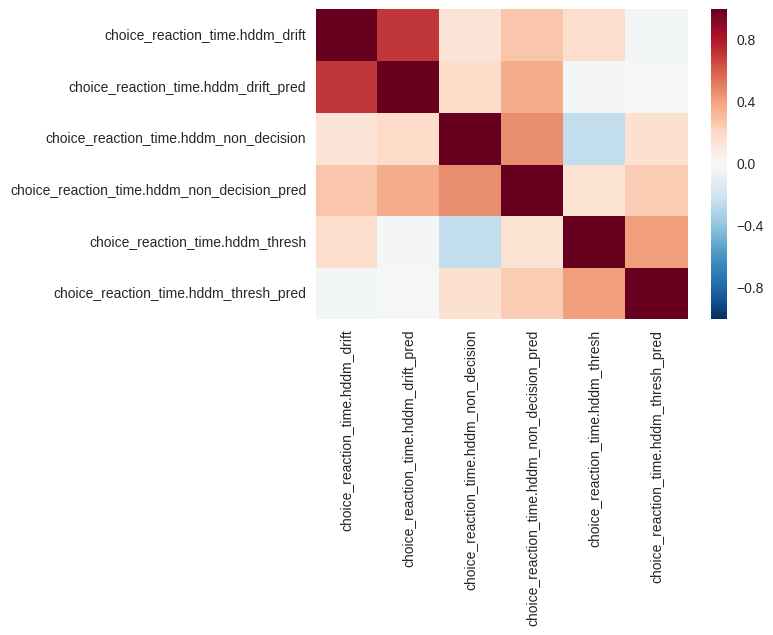

In [129]:
# show one example
df, FA_score, PCA_score, RR_score = out_of_task_prediction(data ,n_components=11, task='choice_reaction_time')
sns.heatmap(df.sort_index(axis=1).corr())

In [130]:
# run it on every task
tasks = np.unique([i.split('.')[0] for i in data.columns])
scores = {}
for task in tasks:
    df, FA_score, PCA_score, RR_score = out_of_task_prediction(data ,n_components=11, 
                                                     task=task,verbose=False)
    scores[task] = {'FA_score': FA_score, 'PCA_score': PCA_score, 'RR_score': RR_score}

Average Reconstruction Score
FA     0.175462
PCA    0.174365
RR     0.011156
dtype: float64


/home/ian/miniconda3/envs/py34/lib/python3.4/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


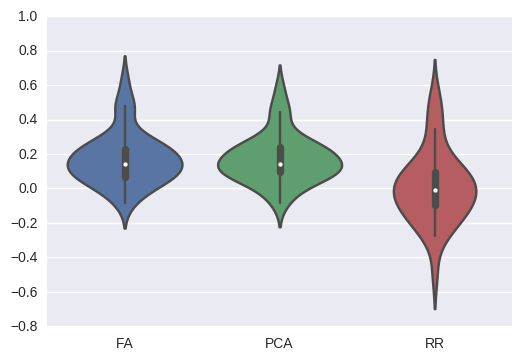

In [132]:
# plot score for FA and PCA reconstruction
score_df = pd.DataFrame({'FA': [i['FA_score'] for i in scores.values()],
                         'PCA': [i['PCA_score'] for i in scores.values()],
                         'RR': [i['RR_score'] for i in scores.values()]}, index = tasks)
print('Average Reconstruction Score')
print(score_df.mean())
sns.violinplot(score_df)

In [133]:
# tasks in order of FA reconstruction success
score_df.sort_values(by='FA', ascending=False)

,FA,PCA,RR
discount_titrate,0.623210,0.581091,0.544277
psychological_refractory_period_two_choices,0.487201,0.404196,0.469557
simon,0.479722,0.476415,0.403934
local_global_letter,0.452720,0.444701,0.347550
choice_reaction_time,0.292782,0.284975,0.133343
holt_laury_survey,0.290793,0.292780,0.241212
ravens,0.287152,0.281594,0.226087
threebytwo,0.262012,0.247324,0.002390
attention_network_task,0.246710,0.238971,0.094728
digit_span,0.231641,0.224309,0.106970
